In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from fbsde import *
from networks import *
from pinn_loss import loss_diff, loss_bc

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
runs = 10
d = 3
fbsde_data_location = "FBSDE_Euler/"
pinn_data_location = "PINN_sin/"
network_type = "NAIS_Net"
epsilon = 0.01
h = 1
iterations_per_level = 1000

In [63]:
f = open(fbsde_data_location + "losses_dimensions_%d.pkl" % (d), "rb")
fbsde_losses = pickle.load(f)
f.close()
f = open(fbsde_data_location + "times_dimensions_%d.pkl" % (d), "rb")
fbsde_times = pickle.load(f)
f.close()
f = open(fbsde_data_location + "terminal_losses_dimensions_%d.pkl" % (d), "rb")
fbsde_terminal_losses = pickle.load(f)
f.close()
f = open(fbsde_data_location + "Y0s_dimensions_%d.pkl" % (d), "rb")
fbsde_Y0s = pickle.load(f)
f.close()

In [64]:
f = open(pinn_data_location + "losses_dimensions_%d.pkl" % (d), "rb")
pinn_losses = pickle.load(f)
f.close()
f = open(pinn_data_location + "times_dimensions_%d.pkl" % (d), "rb")
pinn_times = pickle.load(f)
f.close()
f = open(pinn_data_location + "terminal_losses_dimensions_%d.pkl" % (d), "rb")
pinn_boundary_losses = pickle.load(f)
f.close()

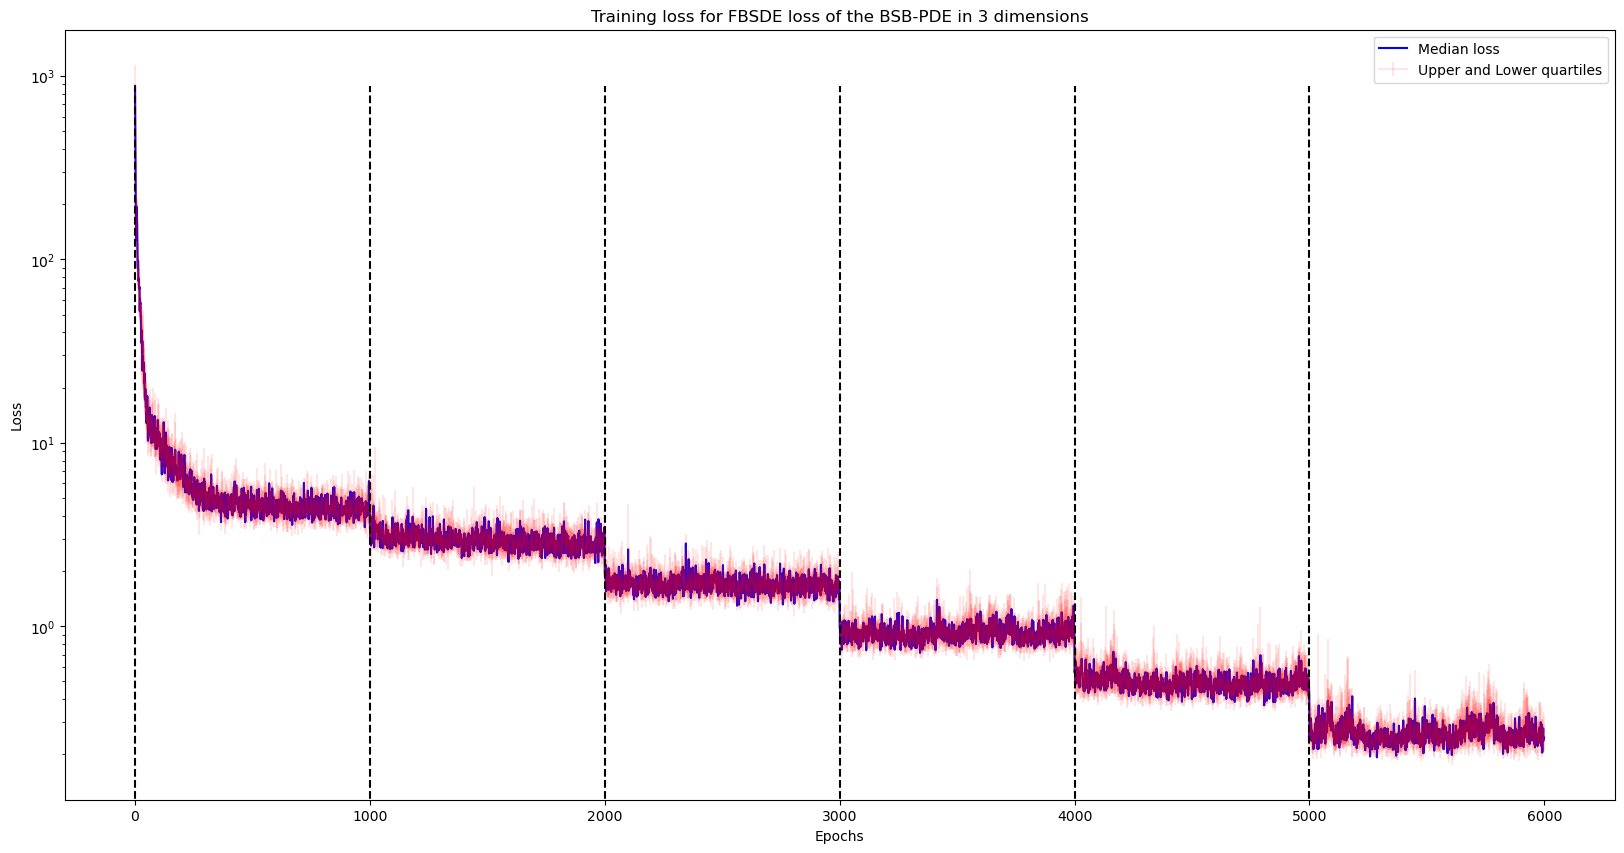

In [40]:
fbsde_losses = np.array(fbsde_losses)
fbsde_avg_losses = np.median(fbsde_losses, axis=0)
fbsde_std_losses = np.std(fbsde_losses, axis=0)
fbsde_lower_quantile_losses = np.quantile(fbsde_losses, 0.25, axis=0)
fbsde_upper_quantile_losses = np.quantile(fbsde_losses, 0.75, axis=0)
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(fbsde_avg_losses, label="Median loss", color="b")
#axs.plot(fbsde_avg_losses+fbsde_std_losses, label="Mean loss + 1 std", color="r", linestyle="dashed")
#axs.plot(fbsde_avg_losses-fbsde_std_losses, label="Mean loss - 1 std", color="r", linestyle="dashed")
axs.errorbar(np.arange(len(fbsde_avg_losses)), fbsde_avg_losses, yerr=np.stack((fbsde_avg_losses - fbsde_lower_quantile_losses, fbsde_upper_quantile_losses - fbsde_avg_losses)), color="r", alpha=0.1, label="Upper and Lower quartiles")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.title.set_text("Training loss for FBSDE loss of the BSB-PDE in %d dimensions" % (d))
axs.set_yscale('log')
# plt.ylim(1e-10, 1)
for i in range(6):
    axs.vlines((i) * 1000, ymin=0, ymax=np.max(fbsde_avg_losses), color="black", linestyle="dashed")
axs.legend()
plt.show()

/rds/general/user/rrp18/home/anaconda3/envs/presentation/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


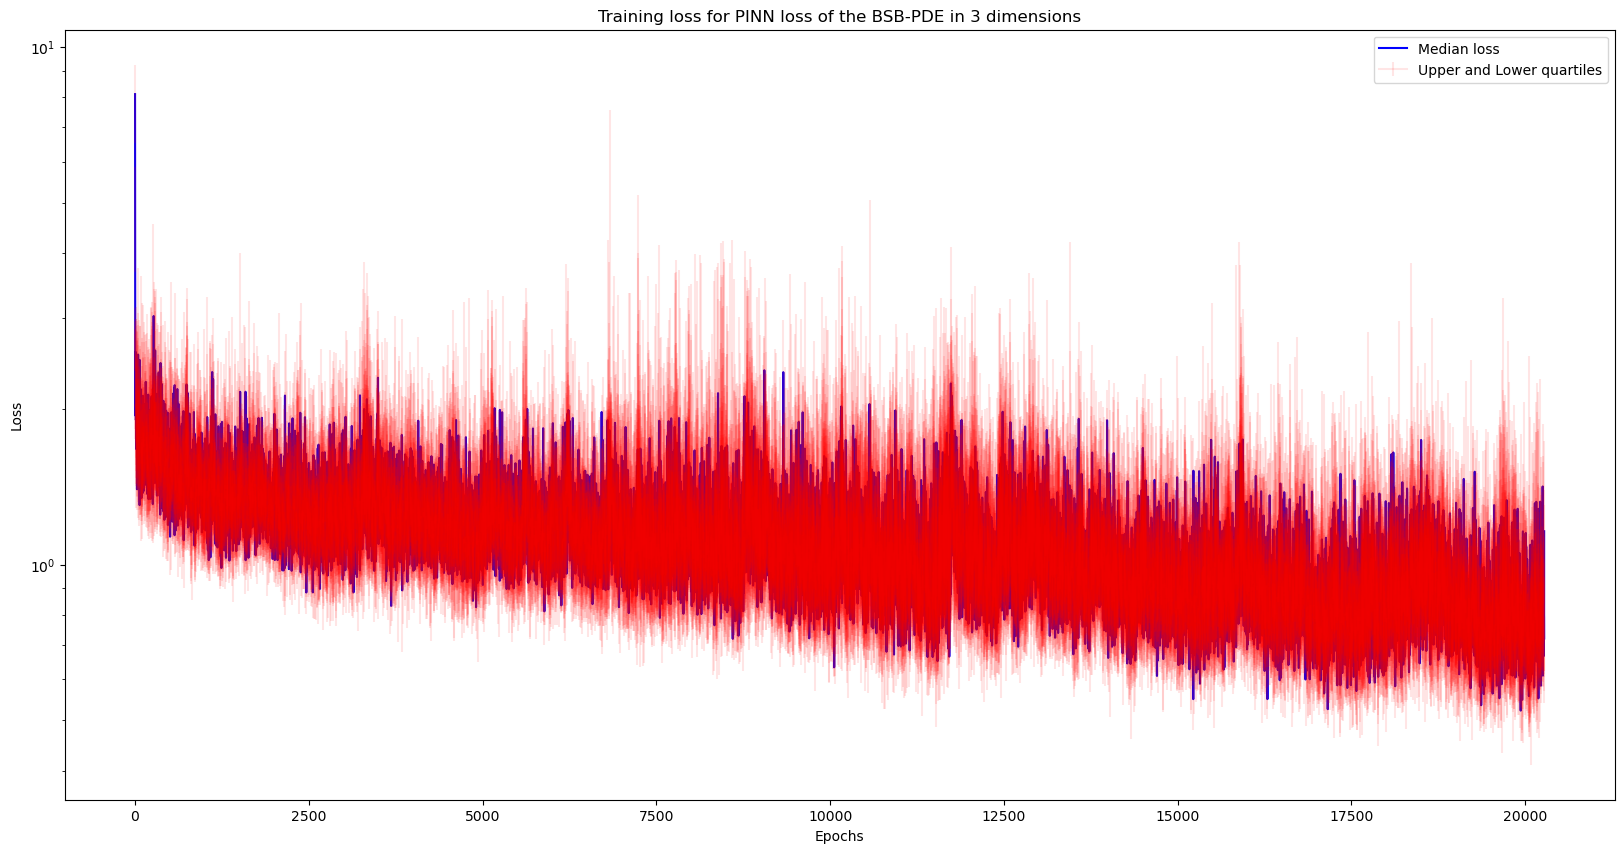

In [41]:
pinn_losses = np.array(pinn_losses)
pinn_avg_losses = np.median(pinn_losses, axis=0)
pinn_std_losses = np.std(pinn_losses, axis=0)
pinn_lower_quantile_losses = np.quantile(pinn_losses, 0.25, axis=0)
pinn_upper_quantile_losses = np.quantile(pinn_losses, 0.75, axis=0)
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(pinn_avg_losses, label="Median loss", color="b")
#axs.plot(pinn_avg_losses+pinn_std_losses, label="Mean loss + 1 std", color="r", linestyle="dashed")
#axs.plot(pinn_avg_losses-pinn_std_losses, label="Mean loss - 1 std", color="r", linestyle="dashed")
axs.errorbar(np.arange(len(pinn_avg_losses)), pinn_avg_losses, yerr=np.stack((pinn_avg_losses - pinn_lower_quantile_losses, pinn_upper_quantile_losses - pinn_avg_losses)), color="r", alpha=0.1, label="Upper and Lower quartiles")
axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.title.set_text("Training loss for PINN loss of the BSB-PDE in %d dimensions" % (d))
axs.set_yscale('log')
# plt.ylim(1e-10, 1)
axs.legend()
plt.show()

In [42]:
r = 0.05
volatility = 0.4
T = 1
fbsde = BS_Barenblatt(volatility, r, 1)
zeta = torch.tensor(int(d / 2) * [1., 0.5] + (d % 2) * [1.], device=device)
def generate_start_points(num_trajectories, zeta):
    if zeta is None:
        return torch.randn((num_trajectories, d), device=device)
    else:
        return zeta.repeat((num_trajectories, 1)).to(device)
def generate_increments(num_trajectories, steps, delta_t):
    return torch.randn((num_trajectories, steps, d), device=device) * np.sqrt(delta_t)
def network_trajectories(network, start_points, W_increments, steps, delta_t):
    num_trajectories = start_points.shape[0]
    X_trajectory = torch.zeros((num_trajectories, steps + 1, d), device=device)
    Y_trajectory = torch.zeros((num_trajectories, steps + 1, 1), device=device)
    ts = torch.arange(steps + 1, device=device) * delta_t
    X_trajectory[:, 0, :] = start_points
    X = X_trajectory[:, 0, :]
    X.requires_grad_(True)
    t_X = torch.cat((torch.zeros((num_trajectories, 1), device=device), X), dim=1)
    Y = network(t_X)
    Z = torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=False)[0]
    Y_trajectory[:, 0, :] = Y
    for i in range(steps):
        #print(W_increments[:,i,:].unsqueeze(-2).shape)
        X = X + fbsde.mu(ts[i], X, Y, Z) * delta_t + (W_increments[:, i, :].unsqueeze(-2) @ fbsde.sigma(ts[i], X, Y)).squeeze(-2)
        X_trajectory[:, i + 1, :] = X
        X.requires_grad_(True)
        t_X = torch.cat((ts[i+1] * torch.ones((num_trajectories, 1), device=device), X), dim=1)
        Y = network(t_X)
        Z = torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=False)[0]
        Y_trajectory[:, i + 1, :] = Y
    return ts, X_trajectory, Y_trajectory
def compute_Y_exacts(ts, X_trajectory):
    Y_trajectory = torch.zeros((X_trajectory.shape[0], X_trajectory.shape[1], 1))
    for i in range(len(ts)):
        Y_trajectory[:, i, 0] = fbsde.exact_solution(ts[i], X_trajectory[:, i, :])
    return Y_trajectory

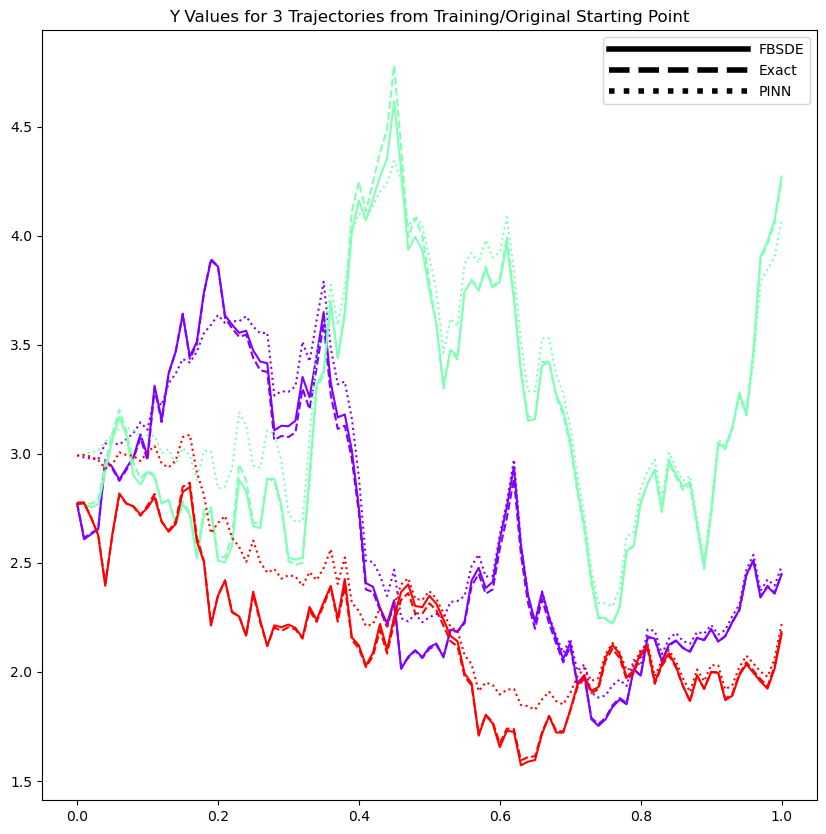

In [59]:
num_trajectories = 3
n = 100
delta_t = fbsde.T/n
start_points = generate_start_points(num_trajectories, zeta)
W_increments = generate_increments(num_trajectories, n, delta_t)
rand_points = generate_start_points(num_trajectories, None)
rand_increments = generate_increments(num_trajectories, n, delta_t)
fbsde_zeta_Xs = []
fbsde_zeta_Ys = []
fbsde_zeta_ts = None
fbsde_rand_Xs = []
fbsde_rand_Ys = []
fbsde_rand_ts = None
pinn_zeta_Xs = []
pinn_zeta_Ys = []
pinn_zeta_ts = None
pinn_rand_Xs = []
pinn_rand_Ys = []
pinn_rand_ts = None
for i in range(runs):
    fbsde_weights = torch.load(fbsde_data_location + ("fbsde_euler_dimensions_%d_run_%d_trained.pt" % (d, i)), map_location=device)
    pinn_weights = torch.load(pinn_data_location + ("pde_pinn_dimensions_%d_run_%d_trained.pt" % (d, i)), map_location=device)
    # change this
    fbsde_net = NAIS_Net_Untied(d+1, 256, 4, 1, torch.sin, epsilon, h).to(device)
    fbsde_net.load_state_dict(fbsde_weights)
    pinn = NAIS_Net_Untied(d+1, 256, 4, 1, torch.sin, epsilon, h).to(device)
    pinn.load_state_dict(pinn_weights)
    fbsde_zeta_ts, fbsde_zeta_X_trajectory, fbsde_zeta_Y_trajectory = network_trajectories(fbsde_net, start_points, W_increments, n, delta_t)
    pinn_zeta_ts, pinn_zeta_X_trajectory, pinn_zeta_Y_trajectory = network_trajectories(pinn, start_points, W_increments, n, delta_t)
    fbsde_zeta_Xs.append(fbsde_zeta_X_trajectory)
    fbsde_zeta_Ys.append(fbsde_zeta_Y_trajectory)
    pinn_zeta_Xs.append(pinn_zeta_X_trajectory)
    pinn_zeta_Ys.append(pinn_zeta_Y_trajectory)
    fbsde_rand_ts, fbsde_rand_X_trajectory, fbsde_rand_Y_trajectory = network_trajectories(fbsde_net, rand_points, rand_increments, n, delta_t)
    pinn_rand_ts, pinn_rand_X_trajectory, pinn_rand_Y_trajectory = network_trajectories(pinn, rand_points, rand_increments, n, delta_t)
    fbsde_rand_Xs.append(fbsde_rand_X_trajectory)
    fbsde_rand_Ys.append(fbsde_rand_Y_trajectory)
    pinn_rand_Xs.append(pinn_rand_X_trajectory)
    pinn_rand_Ys.append(pinn_rand_Y_trajectory)
zeta_Ys_exact = compute_Y_exacts(fbsde_zeta_ts, fbsde_zeta_X_trajectory).detach().cpu().numpy()
rand_Ys_exact = compute_Y_exacts(fbsde_rand_ts, fbsde_rand_X_trajectory).detach().cpu().numpy()
fbsde_zeta_Ys = torch.stack(fbsde_zeta_Ys, dim=1).detach().cpu().numpy()
fbsde_rand_Ys = torch.stack(fbsde_rand_Ys, dim=1).detach().cpu().numpy()
fbsde_zeta_ts = fbsde_zeta_ts.detach().cpu().numpy()
fbsde_rand_ts = fbsde_rand_ts.detach().cpu().numpy()
pinn_zeta_Ys = torch.stack(pinn_zeta_Ys, dim=1).detach().cpu().numpy()
pinn_rand_Ys = torch.stack(pinn_rand_Ys, dim=1).detach().cpu().numpy()
pinn_zeta_ts = pinn_zeta_ts.detach().cpu().numpy()
pinn_rand_ts = pinn_rand_ts.detach().cpu().numpy()


#fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
#fig.suptitle("Y Values for %d Trajectories")
axs.set_title("Y Values for %d Trajectories from Training/Original Starting Point" % (num_trajectories))
#axs[0].set_title("Training/Original Starting Point")
#axs[1].set_title("Starting Points from Std Normal")
colours = plt.cm.rainbow(np.linspace(0, 1, num_trajectories))
for j in range(num_trajectories):
      axs.plot(fbsde_zeta_ts, fbsde_zeta_Ys[j].mean(axis=0), color=colours[j])
      axs.plot(fbsde_zeta_ts, zeta_Ys_exact[j], color=colours[j], linestyle='dashed')
      axs.plot(pinn_zeta_ts, pinn_zeta_Ys[j][[0,1,2,3,4,5,6,7,9]].mean(axis=0), color=colours[j], linestyle='dotted')
      #axs.plot(fbsde_zeta_ts, fbsde_zeta_Ys[j].mean(axis=0), color=colours[j])
      #axs.plot(fbsde_zeta_ts, zeta_Ys_exact[j], color=colours[j], linestyle='dashed')
      #axs.plot(pinn_zeta_ts, pinn_zeta_Ys[j].mean(axis=0), color=colours[j], linestyle='dotted')
      #axs[1].plot(fbsde_rand_ts, fbsde_rand_Ys[j].mean(axis=0), color=colours[j])
      #axs[1].plot(fbsde_rand_ts, rand_Ys_exact[j], color=colours[j], linestyle='dashed')
      #axs[1].plot(pinn_rand_ts, pinn_rand_Ys[j].mean(axis=0), color=colours[j], linestyle='dotted')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='0', lw=4, label='FBSDE'), Line2D([0], [0], color='0', lw=4, label='Exact', linestyle="dashed"), Line2D([0], [0], color='0', lw=4, label='PINN', linestyle="dotted")]
#legend_elements = [Line2D([0], [0], color='0', lw=4, label='FBSDE'), Line2D([0], [0], color='0', lw=4, label='Exact', linestyle="dashed")]
axs.legend(handles=legend_elements, handlelength=10)
plt.show()

In [50]:
pinn_zeta_Ys[2][8]

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

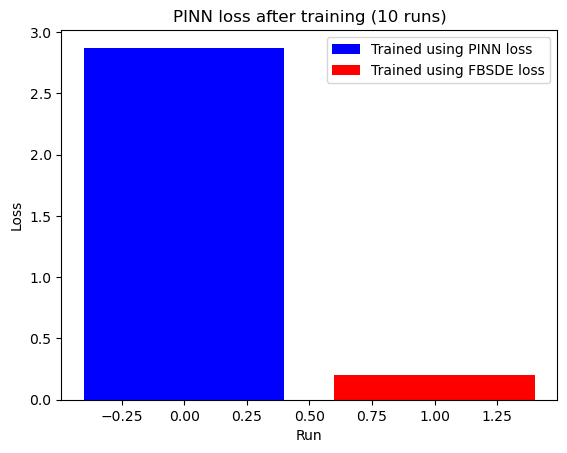

In [88]:
batch_size = 100
pinn_test_losses = []
fbsde_test_losses = []
interior_ts = torch.rand((batch_size, fbsde.T), device=device)
interior_xs = zeta.detach().clone().repeat(batch_size, 1) * torch.exp(-((fbsde.volatility)**2 / 2) * interior_ts + fbsde.volatility * torch.sqrt(interior_ts) * torch.randn((batch_size, d), device=device))

boundary_ts = fbsde.T * torch.ones((batch_size, 1), device=device)
boundary_xs = zeta.detach().clone().repeat(batch_size, 1) * torch.exp(-((fbsde.volatility)**2 / 2) * boundary_ts + fbsde.volatility * torch.sqrt(boundary_ts) * torch.randn((batch_size, d), device=device))

for i in range(runs):
    pinn_weights = torch.load(pinn_data_location + ("pde_pinn_dimensions_%d_run_%d_trained.pt" % (d, i)), map_location=device)
    pinn = NAIS_Net_Untied(d+1, 256, 4, 1, torch.sin, epsilon, h).to(device)
    pinn.load_state_dict(pinn_weights)
    interior_ts_input = interior_ts.detach().clone().requires_grad_(True)
    interior_xs_input = interior_xs.detach().clone().requires_grad_(True)
    interior_sample = torch.cat((interior_ts_input, interior_xs_input), dim=-1)
    u = pinn(interior_sample)
    loss_interior = loss_diff(fbsde, u, interior_ts_input, interior_xs_input)/batch_size
    boundary_ts_input = boundary_ts.detach().clone().requires_grad_(True)
    boundary_xs_input = boundary_xs.detach().clone().requires_grad_(True)
    boundary_sample = torch.cat((boundary_ts_input, boundary_xs_input), dim=-1)
    u = pinn(boundary_sample)
    loss_boundary = (loss_bc(fbsde, u, boundary_xs_input) + loss_diff(fbsde, u, boundary_ts_input, boundary_xs_input))/batch_size
    loss = loss_interior + loss_boundary
    pinn_test_losses.append(loss.item())
    
for i in range(runs):
    weights = torch.load(fbsde_data_location + ("fbsde_euler_dimensions_%d_run_%d_trained.pt") % (d, i), map_location=device)
    net = NAIS_Net_Untied(d+1, 256, 4, 1, torch.sin, epsilon, h).to(device)
    net.load_state_dict(weights)
    interior_ts_input = interior_ts.detach().clone().requires_grad_(True)
    interior_xs_input = interior_xs.detach().clone().requires_grad_(True)
    interior_sample = torch.cat((interior_ts_input, interior_xs_input), dim=-1)
    u = net(interior_sample)
    loss_interior = loss_diff(fbsde, u, interior_ts_input, interior_xs_input)/batch_size
    boundary_ts_input = boundary_ts.detach().clone().requires_grad_(True)
    boundary_xs_input = boundary_xs.detach().clone().requires_grad_(True)
    boundary_sample = torch.cat((boundary_ts_input, boundary_xs_input), dim=-1)
    u = net(boundary_sample)
    loss_boundary = (loss_bc(fbsde, u, boundary_xs_input) + loss_diff(fbsde, u, boundary_ts_input, boundary_xs_input))/batch_size
    loss = loss_interior + loss_boundary
    fbsde_test_losses.append(loss.item())


pinn_test_losses = np.array(pinn_test_losses)
plt.bar(0,np.median(pinn_test_losses[[0,1,2,3,4,5,6,7,9]], axis=-1), color="b", label="Trained using PINN loss")
plt.bar(1,np.median(fbsde_test_losses, axis=-1), color="r", label="Trained using FBSDE loss")
plt.xlabel('Run')
plt.ylabel('Loss')
plt.title("PINN loss after training (%d runs)" % runs)
plt.legend()

In [75]:
np.median(pinn_test_losses, axis=-1)

nan

In [81]:
pinn_test_losses[0,1,2,3,4,5,6,7,9]

TypeError: list indices must be integers or slices, not tuple